In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from epsgreedy_slate import epsilon_greedy
from exp3_slate import Exp3
from exp4_slate import Exp4

sns.set_theme()

## Preprocessing Movielens data

In [4]:
print('reading movielens 1m data')
ratings = pd.read_csv('../../data/ml-1m/ratings.dat', sep='::', names=['UserID','MovieID','Rating','Timestamp'], encoding = "ISO-8859-1")
movies = pd.read_csv('../../data/ml-1m/movies.dat', sep='::', names=['MovieID','Title','Genres'], encoding = "ISO-8859-1")
users = pd.read_csv('../../data/ml-1m/users.dat', sep='::', names=['UserID','Gender','Age','Occupation', 'Zip'], encoding = "ISO-8859-1")
#ratings = pd.read_csv('../data/ml-1m/ratings.dat', sep=':', usecols=range(0,5,2), names=['UserID','MovieID','Rating'], encoding = "ISO-8859-1")
#movies = pd.read_csv('../data/ml-1m/movies.dat', sep=':', usecols=range(0,5,2), names=['MovieID','Title','Genres'], encoding = "ISO-8859-1")
#users = pd.read_csv('../data/ml-1m/users.dat', sep=':', usecols=range(0,7,2), names=['UserID','Gender','Age','Occupation'], encoding = "ISO-8859-1")

movies = movies.join(movies['Genres'].str.get_dummies().astype(bool))
movies.drop('Genres', inplace=True, axis=1)
ratings['Liked'] = ratings['Rating'].apply(lambda x: 1 if x == 5 else 0)

reading movielens 1m data


/var/folders/kb/56818rxn0c1bys2p_gkxx0w40000gn/T/ipykernel_86971/612987619.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('../../data/ml-1m/ratings.dat', sep='::', names=['UserID','MovieID','Rating','Timestamp'], encoding = "ISO-8859-1")
/var/folders/kb/56818rxn0c1bys2p_gkxx0w40000gn/T/ipykernel_86971/612987619.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv('../../data/ml-1m/movies.dat', sep='::', names=['MovieID','Title','Genres'], encoding = "ISO-8859-1")
/var/folders/kb/56818rxn0c1bys2p_gkxx0w40000gn/T/ipykernel_86971/612987619.py:4: ParserWarning:

In [5]:
topids = ratings['MovieID'].value_counts().head(50)
top_movies = movies.loc[movies['MovieID'].isin(topids.index)]
print(topids.index)

Int64Index([2858,  260, 1196, 1210,  480, 2028,  589, 2571, 1270,  593, 1580,
            1198,  608, 2762,  110, 2396, 1197,  527, 1617, 1265, 1097, 2628,
            2997,  318,  858,  356, 2716,  296, 1240,    1, 1214, 2916,  457,
            3578, 1200,  541, 2987, 1259,   50,   34, 2791,  780, 3175, 1193,
             919,  924, 1127, 2355, 1387, 1221],
           dtype='int64')


In [6]:
top_ratings = ratings.loc[ratings['MovieID'].isin(topids.index)]
top_ratings

,UserID,MovieID,Rating,Timestamp,Liked
0,1,1193,5,978300760,1
4,1,2355,5,978824291,1
5,1,1197,3,978302268,0
9,1,919,4,978301368,0
15,1,2791,4,978302188,0
...,...,...,...,...,...
1000184,6040,2791,4,956715569,0
1000186,6040,527,5,956704219,1
1000193,6040,541,4,956715288,0
1000200,6040,2028,5,956704519,1


In [7]:
top_users = users.loc[users['UserID'].isin(top_ratings['UserID'])]
top_users

,UserID,Gender,Age,Occupation,Zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [8]:
data = pd.merge(top_ratings, top_users, on='UserID').sample(frac=1,random_state=5).reset_index(drop=True)
data

,UserID,MovieID,Rating,Timestamp,Liked,Gender,Age,Occupation,Zip
0,4948,2987,3,962641059,0,M,45,2,94618
1,3751,2987,4,966130409,0,F,35,12,55555
2,2166,1387,4,974616331,0,M,1,10,99203
3,1916,1240,4,974694442,0,M,45,7,90405
4,3860,1580,4,965860526,0,M,45,17,44129
...,...,...,...,...,...,...,...,...,...
109799,316,780,5,976465927,1,M,56,13,90740
109800,5604,34,1,959459461,0,M,35,15,63117
109801,1144,2028,4,974873472,0,M,25,7,94025
109802,1057,2987,4,974953003,0,M,45,17,73069


Bandit implementations require knowledge of time horizon, number of arms (movies) k, and the reward function for taking action A at time step t. When evaluating offline using replay, the time horizon can vary. This can influence the performance of the algorithms as the value updates depend on the time horizon. THe time horizon can vary between 0 and the length of dataset, however the expected time horizon is length of dataset / k.

In [25]:
horizon = len(data.index)
k = len(topids.index)
M = k**2

def reward(t,As):
    if data['MovieID'].iloc[t] in (topids.index[As]):
        return data['Liked'].iloc[t], np.where(topids.index == data['MovieID'].iloc[t])[0][0]
    return None, None

expert = {}
diag = np.zeros((k,k))
np.fill_diagonal(diag, 1)
for i, gender in enumerate(data['Gender'].unique()):
    expert[gender] = diag
    for j in range(1,int(M/k)):
        new_diag = np.roll(diag, i*j, axis=1)
        expert[gender] = np.concatenate((expert[gender], new_diag), axis=0)

def advice(t):
    return expert[data['Gender'].iloc[t]]

print(expert['F'])

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [13]:
epsgreedy = epsilon_greedy(k,reward,horizon)

In [26]:
eta = np.sqrt(2*np.log(k)/(horizon*k))
exp3 = Exp3(k,reward,horizon,eta)

In [28]:
eta = np.sqrt(2*np.log(M)/(horizon*k))
exp4 = Exp4(M,reward,horizon,eta,advice)

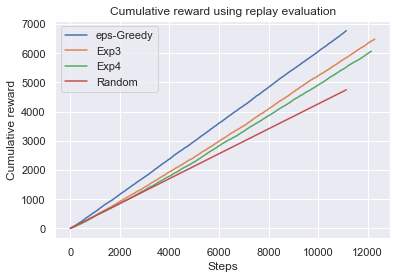

In [29]:
random = np.full(len(epsgreedy),data['Liked'].value_counts(normalize=True)[1])

fig1, ax1 = plt.subplots()
ax1.plot(range(len(epsgreedy)), np.cumsum(epsgreedy), label='eps-Greedy')
ax1.plot(range(len(exp3)), np.cumsum(exp3), label='Exp3')
ax1.plot(range(len(exp4)), np.cumsum(exp4), label='Exp4')
ax1.plot(range(len(random)), np.cumsum(random), label='Random')
ax1.set_title("Cumulative reward using replay evaluation")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Cumulative reward")
plt.legend()

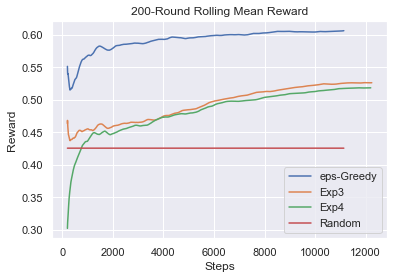

In [24]:
cumulative_random = np.cumsum(random) / np.linspace(1, len(random), len(random))
cumulative_epsgreedy = np.cumsum(epsgreedy) / np.linspace(1, len(epsgreedy), len(epsgreedy))
cumulative_exp3 = np.cumsum(exp3) / np.linspace(1, len(exp3), len(exp3))
cumulative_exp4 = np.cumsum(exp4) / np.linspace(1, len(exp4), len(exp4))

fig1, ax1 = plt.subplots()
ax1.plot(range(len(epsgreedy)), np.asarray(pd.Series(cumulative_epsgreedy).rolling(200).mean()), label='eps-Greedy')
ax1.plot(range(len(exp3)), np.asarray(pd.Series(cumulative_exp3).rolling(200).mean()), label='Exp3')
ax1.plot(range(len(exp4)), np.asarray(pd.Series(cumulative_exp4).rolling(200).mean()), label='Exp4')
ax1.plot(range(len(random)), np.asarray(pd.Series(cumulative_random).rolling(200).mean()), label='Random')
ax1.set_title("200-Round Rolling Mean Reward")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Reward")
plt.legend()